In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from alexnet import AlexNet

In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0, ))])

mnist = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(mnist, batch_size=128,shuffle=False)

test = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False)
len(mnist), len(test)

(60000, 10000)

In [2]:
publ_scores = torch.load('./curv_scores/publ_scores.pt', weights_only=True)
priv_scores = torch.load('./curv_scores/priv_scores.pt', weights_only=True)
priv10_scores = torch.load('./curv_scores/priv10_scores.pt', weights_only=True)

In [3]:
def scale(x):
    v_min, v_max = x.min(), x.max()
    new_min, new_max = 0, 1
    return (x - v_min) / (v_max - v_min) * (new_max - new_min) + new_min

In [4]:
publ_scores = scale(publ_scores)
priv_scores = scale(priv_scores)
priv10_scores = scale(priv10_scores)

In [11]:
torch.save(publ_scores, './publ_scores.pt')
torch.save(priv_scores, 'eps5_scores.pt')
torch.save(priv10_scores, 'eps10_scores.pt')

In [5]:
df = pd.DataFrame({
    "publ": publ_scores,
    "eps5": priv_scores,
    "eps10": priv10_scores
})

df.head()

,publ,eps5,eps10
0,8.750455e-03,5.359010e-01,4.021979e-03
1,7.122338e-07,4.282255e-05,3.317338e-09
2,2.328801e-05,7.559590e-13,3.135634e-07
3,2.596236e-05,1.044550e-08,5.677903e-16
4,1.412268e-04,6.388890e-08,2.476190e-08


In [6]:
df['publ rank'] = df['publ'].rank(ascending=False)
df['eps5 rank'] = df['eps5'].rank(ascending=False)
df['eps10 rank'] = df['eps10'].rank(ascending=False)
df.head()

,publ,eps5,eps10,publ rank,eps5 rank,eps10 rank
0,8.750455e-03,5.359010e-01,4.021979e-03,3315.0,1709.0,10108.0
1,7.122338e-07,4.282255e-05,3.317338e-09,53048.0,22022.0,41312.0
2,2.328801e-05,7.559590e-13,3.135634e-07,31082.0,50655.0,29855.0
3,2.596236e-05,1.044550e-08,5.677903e-16,30191.0,37623.0,58765.0
4,1.412268e-04,6.388890e-08,2.476190e-08,17566.0,35359.0,36248.0


In [14]:
def spearman(rankx, ranky):
    total = 0
    n = len(rankx)
    for i in range(n):
        total += (rankx[i] - ranky[i]) ** 2
    return 1 - 6 * total / (n * (n ** 2 - 1))

In [15]:
spearman(df['publ rank'].to_numpy(), df['eps5 rank'].to_numpy())

np.float64(-0.00017238109357564646)

In [19]:
spearman(df['publ rank'].to_numpy(), df['eps10 rank'].to_numpy())

np.float64(0.0015616058128921084)

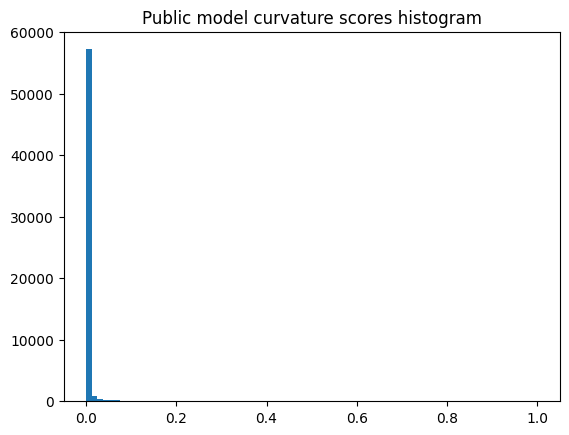

In [7]:
plt.hist(df['publ'], bins=80)
plt.title('Public model curvature scores histogram')
plt.show()

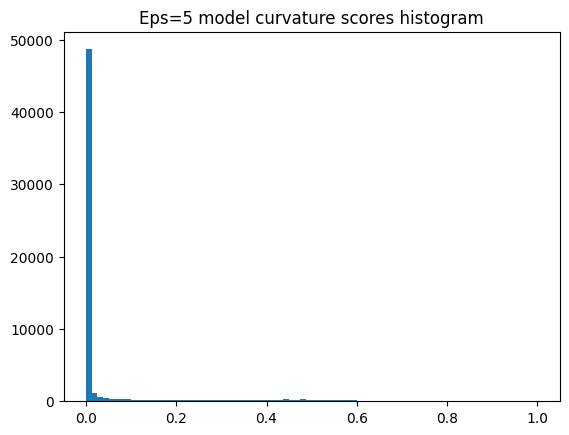

In [9]:
plt.hist(df['eps5'], bins=80)
plt.title('Eps=5 model curvature scores histogram')
plt.show()

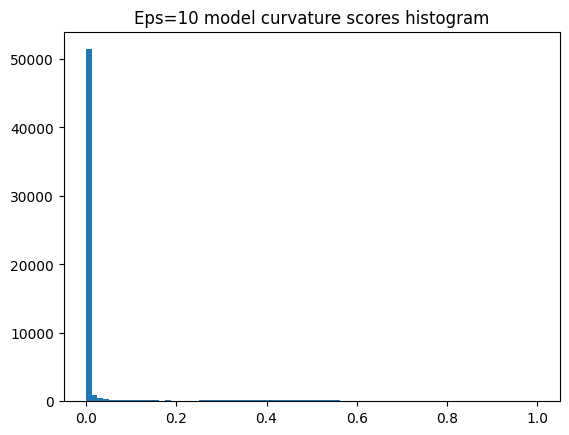

In [10]:
plt.hist(df['eps10'], bins=80)
plt.title('Eps=10 model curvature scores histogram')
plt.show()

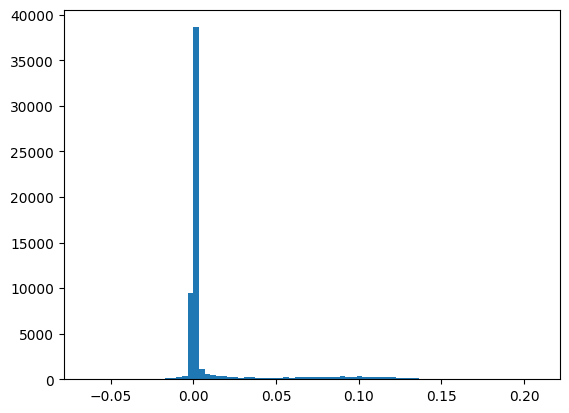

In [22]:
df['5 diff'] = df['eps5'] - df['publ']
plt.hist(df['5 diff'], bins=80)
plt.show()

In [20]:
(publ_scores > 0.8).nonzero()

tensor([[43454]])

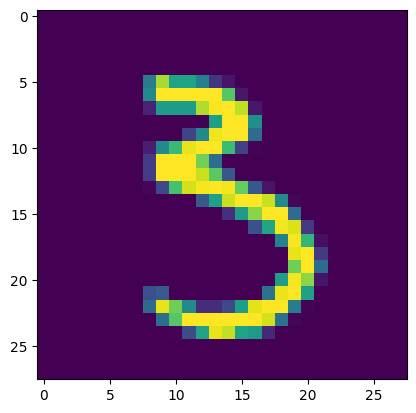

In [23]:
plt.imshow(mnist[43454][0].squeeze())

In [33]:
(priv10_scores > 0.95).nonzero()

tensor([[25666],
        [27106],
        [31372],
        [31515],
        [45238],
        [53267]])

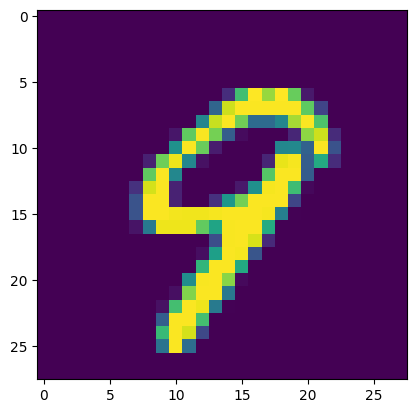

In [40]:
plt.imshow(mnist[53267][0].squeeze())